# A Transfer Learning and Optimized CNN Based Intrusion Detection System for Internet of Vehicles 
This is the code for the paper entitled "**A Transfer Learning and Optimized CNN Based Intrusion Detection System for Internet of Vehicles**" accepted in IEEE International Conference on Communications (IEEE ICC).  
Authors: Li Yang (lyang339@uwo.ca) and Abdallah Shami (Abdallah.Shami@uwo.ca)  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

**Notebook 1: df pre-processing**  
Procedures:  
&nbsp; 1): Read the dfset  
&nbsp; 2): Transform the tabular df into images  
&nbsp; 3): Display the transformed images  
&nbsp; 4): Split the training and test set  

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import math
import random
import matplotlib.pyplot as plt
import shutil
from sklearn.preprocessing import QuantileTransformer
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

## Read the Car-Hacking/CAN-Intrusion dfset
The complete Car-Hacking dataset is publicly available at: https://ocslab.hksecurity.net/Datasets/CAN-intrusion-dataset  
In this repository, due to the file size limit of GitHub, we use the 5% subset.

In [2]:
#Read dataset
df=pd.read_csv('data/clean/cicids2017/all_data.csv')
df['padding'] = 0
print(df['Label'].unique())

['Benign' 'DDoS' 'PortScan' 'Bot' 'Infiltration'
 'Web Attack Ã\x82Â\x96 Brute Force' 'Web Attack Ã\x82Â\x96 XSS'
 'Web Attack Ã\x82Â\x96 Sql Injection' 'FTP-Patator' 'SSH-Patator'
 'DoS slowloris' 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye'
 'Heartbleed']


In [3]:
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Mean,...,Fwd Act Data Packets,Fwd Seg Size Min,Active Mean,Active Max,Active Min,Idle Mean,Idle Max,Idle Min,Label,padding
0,3.0,2.0,0.0,12.0,0.0,6.0,6.0,0.000000,0.0,0.0,...,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0
1,109.0,1.0,1.0,6.0,6.0,6.0,6.0,0.000000,6.0,6.0,...,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0
2,52.0,1.0,1.0,6.0,6.0,6.0,6.0,0.000000,6.0,6.0,...,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0
3,34.0,1.0,1.0,6.0,6.0,6.0,6.0,0.000000,6.0,6.0,...,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0
4,3.0,2.0,0.0,12.0,0.0,6.0,6.0,0.000000,0.0,0.0,...,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2230950,32215.0,4.0,2.0,112.0,152.0,28.0,28.0,0.000000,76.0,76.0,...,3.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0
2230951,324.0,2.0,2.0,84.0,362.0,42.0,42.0,0.000000,181.0,181.0,...,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0
2230952,82.0,2.0,1.0,31.0,6.0,31.0,15.5,21.920311,6.0,6.0,...,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0
2230953,1048635.0,6.0,2.0,192.0,256.0,32.0,32.0,0.000000,128.0,128.0,...,5.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0


In [4]:
import re

def clean_label(label):
    if 'Web Attack' in label:
        # 去除亂碼並保留原始類型
        return re.sub(r'Ã.*Â\x96', '–', label)  # 將亂碼替換為正常符號 "–"
    return label

# 清理標籤
df['Label'] = df['Label'].apply(clean_label)
print(df['Label'].unique())

['Benign' 'DDoS' 'PortScan' 'Bot' 'Infiltration'
 'Web Attack – Brute Force' 'Web Attack – XSS'
 'Web Attack – Sql Injection' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris'
 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed']


In [5]:
# The labels of the dataset. "R" indicates normal patterns, and there are four types of attack (DoS, fuzzy. gear spoofing, and RPM spoofing zttacks)
df.Label.value_counts().sort_index()

Benign                        1894575
Bot                              1431
DDoS                           128014
DoS GoldenEye                   10285
DoS Hulk                       172743
DoS Slowhttptest                 5228
DoS slowloris                    5383
FTP-Patator                      5931
Heartbleed                         11
Infiltration                       36
PortScan                         1956
SSH-Patator                      3219
Web Attack – Brute Force         1470
Web Attack – Sql Injection         21
Web Attack – XSS                  652
Name: Label, dtype: int64

In [6]:
# 標籤映射
label_mapping = {
    'Benign': 'Benign',  # 正常流量
    'DoS Hulk': 'DoS',
    'DDoS': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'PortScan': 'Port-scan',
    'FTP-Patator': 'Brute-force',
    'SSH-Patator': 'Brute-force',
    'Web Attack – Brute Force': 'Web-attacks',
    'Web Attack – XSS': 'Web-attacks',
    'Web Attack – Sql Injection': 'Web-attacks',
    'Bot': 'Botnets',
    'Infiltration': 'Botnets',
    'Heartbleed': 'Botnets'
}
# 將標籤重新分類
df['Label'] = df['Label'].map(label_mapping)

# 檢查重新分類後的標籤
print(df['Label'].unique())  # 會顯示 ['Benign', 'DoS attacks', 'Port-scan attacks', ...]


['Benign' 'DoS' 'Port-scan' 'Botnets' 'Web-attacks' 'Brute-force']


In [7]:
print(df['Label'].value_counts())

Benign         1894575
DoS             321653
Brute-force       9150
Web-attacks       2143
Port-scan         1956
Botnets           1478
Name: Label, dtype: int64


In [8]:
# 設定下採樣的數量
target_samples = 20000

# df = df.drop(df[(df['Label'] == 'Benign') & (df.index >= target_samples)].index)
# df = df.drop(df[(df['Label'] == 'DoS') & (df.index >= target_samples)].index)

# 下採樣 Benign 和 DoS 類別
benign_samples = df[df['Label'] == 'Benign'].sample(n=target_samples, random_state=42)
dos_samples = df[df['Label'] == 'DoS'].sample(n=target_samples, random_state=42)

# 保持其他類別數量不變
brute_force_samples = df[df['Label'] == 'Brute-force']
web_attack_samples = df[df['Label'] == 'Web-attacks']
port_scan_samples = df[df['Label'] == 'Port-scan']
botnet_samples = df[df['Label'] == 'Botnets']

# 合併所有樣本
df = pd.concat([benign_samples, dos_samples, brute_force_samples,
                           web_attack_samples, port_scan_samples, botnet_samples])


# 查看新的資料集分佈
print(df['Label'].value_counts())

#共54725張圖

Benign         20000
DoS            20000
Brute-force     9150
Web-attacks     2143
Port-scan       1956
Botnets         1478
Name: Label, dtype: int64


## Data Transformation
Convert tabular data to images
Procedures:
1. Use quantile transform to transform the original data samples into the scale of [0,255], representing pixel values
2. Generate images for each category (Normal, DoS, Fuzzy, Gear, RPM), each image consists of 27 data samples with 9 features. Thus, the size of each image is 9*9*3, length 9, width 9, and 3 color channels (RGB).

In [9]:
# Transform all features into the scale of [0,1]
numeric_features = df.dtypes[df.dtypes != 'object'].index
scaler = QuantileTransformer() 
df[numeric_features] = scaler.fit_transform(df[numeric_features])

In [10]:
# Multiply the feature values by 255 to transform them into the scale of [0,255]
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x*255))

In [11]:
df.describe()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Mean,...,Init Bwd Win Bytes,Fwd Act Data Packets,Fwd Seg Size Min,Active Mean,Active Max,Active Min,Idle Mean,Idle Max,Idle Min,padding
count,54727.000000,54727.000000,54727.000000,54727.000000,54727.000000,54727.000000,54727.000000,54727.000000,54727.000000,54727.000000,...,54727.000000,54727.000000,54727.000000,54727.000000,54727.000000,54727.000000,54727.000000,54727.000000,54727.000000,54727.0
mean,127.498844,126.186767,126.030916,125.446197,120.331605,125.450277,125.443670,107.656599,120.323727,120.330771,...,117.458693,120.231836,127.556277,65.493488,65.493540,65.491783,66.999434,66.997944,67.000352,0.0
std,73.615030,75.167146,75.388237,76.748545,82.923097,76.683160,76.720025,93.551153,83.078478,83.080842,...,85.728196,82.467145,64.985312,100.173479,100.173572,100.171495,100.507025,100.505345,100.508224,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,63.750307,52.327327,54.114114,61.899399,66.876877,67.004505,63.303303,0.000000,69.684685,63.813814,...,0.000000,92.912913,59.091592,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,127.472905,127.882883,130.180180,127.755255,127.500000,128.010511,127.505328,131.073574,127.500000,125.713213,...,134.647147,142.560060,185.187688,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,191.235446,187.102102,195.270270,191.186186,202.800300,191.250000,191.441441,191.317993,191.951952,193.100601,...,171.914414,190.930931,185.187688,191.238397,191.236709,191.225562,191.236966,190.420420,191.274447,0.0
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,0.0


All features are in the same scale of [0,255]

### Generate images for each class

In [12]:
df0=df[df['Label']=='Benign'].drop(['Label'],axis=1)
df1=df[df['Label']=='DoS'].drop(['Label'],axis=1)
df2=df[df['Label']=='Brute-force'].drop(['Label'],axis=1)
df3=df[df['Label']=='Web-attacks'].drop(['Label'],axis=1)
df4=df[df['Label']=='Port-scan'].drop(['Label'],axis=1)
df5=df[df['Label']=='Botnets'].drop(['Label'],axis=1)

In [13]:
# Generate 8*8 color images for class 0 (Benign)
count=0
ims = []

image_path = "data/image_gray/cicids2017/train/Benign/"
os.makedirs(image_path, exist_ok=True)

for i in range(len(df0)):  
    im = df0.iloc[i].values  # 取得第 i 筆樣本 (長度為 64)
    im = im.reshape(8, 8)  # 轉換為 8x8 矩陣 (灰階影像)

    # 轉換成 PIL 影像並儲存
    new_image = Image.fromarray(im, mode='L')  # 'L' 表示灰階
    new_image.save(os.path.join(image_path, f"{i}.png"))

In [14]:
# Generate 8*8 color images for class 1 (DoS)
count=0
ims = []

image_path = "data/image_gray/cicids2017/train/DoS/"
os.makedirs(image_path, exist_ok=True)

for i in range(len(df1)):  
    im = df0.iloc[i].values  # 取得第 i 筆樣本 (長度為 64)
    im = im.reshape(8, 8)  # 轉換為 8x8 矩陣 (灰階影像)

    # 轉換成 PIL 影像並儲存
    new_image = Image.fromarray(im, mode='L')  # 'L' 表示灰階
    new_image.save(os.path.join(image_path, f"{i}.png"))

In [15]:
# Generate 8*8 color images for class 2 (Brute-force)
count=0
ims = []

image_path = "data/image_gray/cicids2017/train/Brute-force/"
os.makedirs(image_path, exist_ok=True)

for i in range(len(df2)):  
    im = df0.iloc[i].values  # 取得第 i 筆樣本 (長度為 64)
    im = im.reshape(8, 8)  # 轉換為 8x8 矩陣 (灰階影像)

    # 轉換成 PIL 影像並儲存
    new_image = Image.fromarray(im, mode='L')  # 'L' 表示灰階
    new_image.save(os.path.join(image_path, f"{i}.png"))

In [16]:
# Generate 8*8 color images for class 3 (Web-attacks)
count=0
ims = []

image_path = "data/image_gray/cicids2017/train/Web-attacks/"
os.makedirs(image_path, exist_ok=True)

for i in range(len(df3)):  
    im = df0.iloc[i].values  # 取得第 i 筆樣本 (長度為 64)
    im = im.reshape(8, 8)  # 轉換為 8x8 矩陣 (灰階影像)

    # 轉換成 PIL 影像並儲存
    new_image = Image.fromarray(im, mode='L')  # 'L' 表示灰階
    new_image.save(os.path.join(image_path, f"{i}.png"))

In [17]:
# Generate 8*8 color images for class 4 (Port-scan)
count=0
ims = []

image_path = "data/image_gray/cicids2017/train/Port-scan/"
os.makedirs(image_path, exist_ok=True)

for i in range(len(df4)):  
    im = df0.iloc[i].values  # 取得第 i 筆樣本 (長度為 64)
    im = im.reshape(8, 8)  # 轉換為 8x8 矩陣 (灰階影像)

    # 轉換成 PIL 影像並儲存
    new_image = Image.fromarray(im, mode='L')  # 'L' 表示灰階
    new_image.save(os.path.join(image_path, f"{i}.png"))

In [18]:
# Generate 8*8 color images for class 5 (Botnets)
count=0
ims = []

image_path = "data/image_gray/cicids2017/train/Botnets/"
os.makedirs(image_path, exist_ok=True)

for i in range(len(df5)):  
    im = df0.iloc[i].values  # 取得第 i 筆樣本 (長度為 64)
    im = im.reshape(8, 8)  # 轉換為 8x8 矩陣 (灰階影像)

    # 轉換成 PIL 影像並儲存
    new_image = Image.fromarray(im, mode='L')  # 'L' 表示灰階
    new_image.save(os.path.join(image_path, f"{i}.png"))

## Split the training and test set 

In [19]:
# # Create folders to store images
# Train_Dir='data/image_gray/cicids2017/train/'
# Val_Dir='data/image_gray/cicids2017/val/'
# allimgs=[]
# for subdir in os.listdir(Train_Dir):
#     for filename in os.listdir(os.path.join(Train_Dir,subdir)):
#         filepath=os.path.join(Train_Dir,subdir,filename)
#         allimgs.append(filepath)
# print(len(allimgs)) # Print the total number of images

In [20]:
# #split a test set from the dataset, train/test size = 80%/20%
# Numbers=len(allimgs)//5 	#size of test set (20%)

# def mymovefile(srcfile,dstfile):
#     if not os.path.isfile(srcfile):
#         print ("%s not exist!"%(srcfile))
#     else:
#         fpath,fname=os.path.split(dstfile)    
#         if not os.path.exists(fpath):
#             os.makedirs(fpath)               
#         shutil.move(srcfile,dstfile)          
#         #print ("move %s -> %s"%(srcfile,dstfile))

In [21]:
# # The size of test set
# Numbers

In [22]:
# # Create the test set
# val_imgs=random.sample(allimgs,Numbers)
# for img in val_imgs:
#     dest_path=img.replace(Train_Dir,Val_Dir)
#     mymovefile(img,dest_path)
# print('Finish creating test set')

In [23]:
#resize the images 224*224 for better CNN training
def get_224(folder,dstdir):
    imgfilepaths=[]
    for root,dirs,imgs in os.walk(folder):
        for thisimg in imgs:
            thisimg_path=os.path.join(root,thisimg)
            imgfilepaths.append(thisimg_path)
    for thisimg_path in imgfilepaths:
        dir_name,filename=os.path.split(thisimg_path)
        dir_name=dir_name.replace(folder,dstdir)
        new_file_path=os.path.join(dir_name,filename)
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
        img=cv2.imread(thisimg_path)
        img=cv2.resize(img,(224,224))
        cv2.imwrite(new_file_path,img)
    print('Finish resizing'.format(folder=folder))

In [24]:
DATA_DIR_224='data/image_gray/cicids2017/train_224/'
get_224(folder='data/image_gray/cicids2017/train/',dstdir=DATA_DIR_224)

Finish resizing


In [25]:
# DATA_DIR2_224='data/image/cicids2017/val_224/'
# get_224(folder='data/image/cicids2017/val/',dstdir=DATA_DIR2_224)

### Display samples for each category

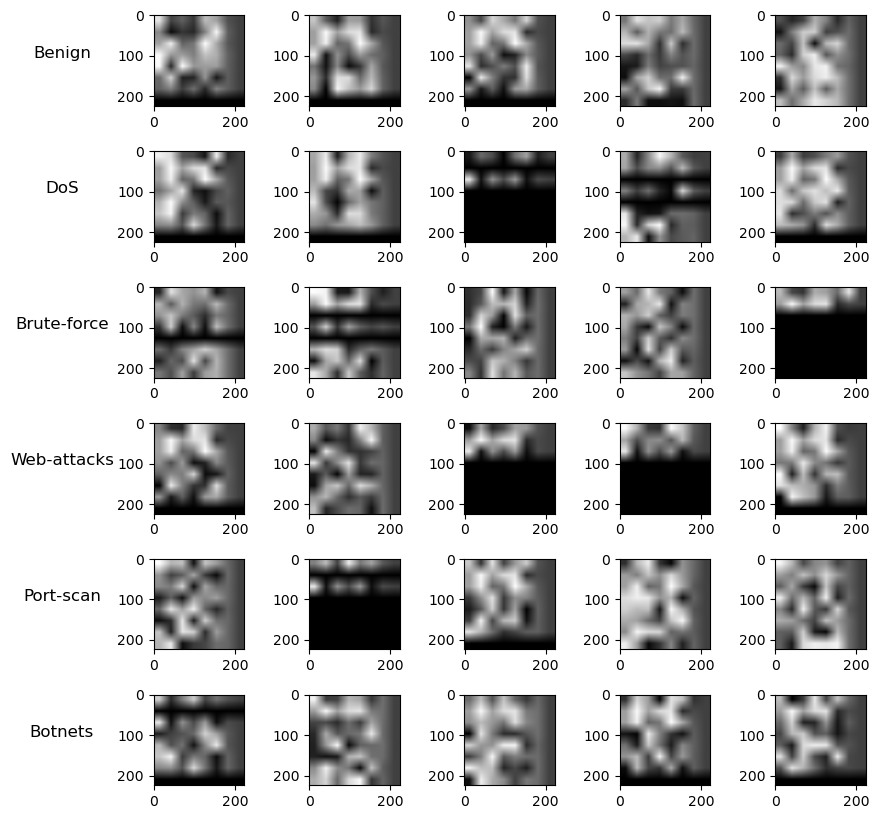

In [26]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# 設定每個類別資料夾的路徑
base_dir = 'data/image_gray/cicids2017/train_224/'  # 圖片資料集根目錄
classes = ["Benign", "DoS", "Brute-force", "Web-attacks", "Port-scan", "Botnets"]  # 類別名稱
map = ["Benign", "DoS", "Brute-force", "Web-attacks", "Port-scan", "Botnets"]

# 每個類別選 5 張圖片
num_images_per_class = 5

# 建立子圖佈局：6 個類別，每個類別 5 張圖
fig, axes = plt.subplots(nrows=len(classes), ncols=num_images_per_class, figsize=(10, 10))
# fig.suptitle("Sample Images from Each Class", fontsize=16)
fig.subplots_adjust(wspace=0.01, hspace=0.5)  # 縮小間距

# 從每個類別中選取圖片並繪製
for row, class_name in enumerate(classes):
    class_dir = os.path.join(base_dir, class_name)
    image_files = os.listdir(class_dir)  # 取得該類別所有圖片檔案名稱
    random_images = random.sample(image_files, num_images_per_class)  # 隨機選 5 張圖片
    
    for col, img_name in enumerate(random_images):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)  # 讀取圖片
        axes[row, col].imshow(img)  # 在子圖中顯示圖片
        # axes[row, col].axis('off')  # 移除座標軸
    
    # 在每一行的第一張圖加上類別標題
    axes[row, 0].set_ylabel(map[row], rotation=0, labelpad=40, fontsize=12)

# plt.tight_layout(rect=[1, 1, 1, 1])
plt.show()
